<a href="https://colab.research.google.com/github/fernandoIroth/202055202045-Nando/blob/master/mangkok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download fernandoiroth/eating
!mkdir dataset

 98% 361M/367M [00:03<00:00, 122MB/s]
100% 367M/367M [00:03<00:00, 99.1MB/s]


In [4]:
!unzip /content/eating.zip -d /content/dataset

Archive:  /content/eating.zip
  inflating: /content/dataset/cangkir/cangkir (1).jpg  
  inflating: /content/dataset/cangkir/cangkir (10).jpg  
  inflating: /content/dataset/cangkir/cangkir (100).jpg  
  inflating: /content/dataset/cangkir/cangkir (11).jpg  
  inflating: /content/dataset/cangkir/cangkir (12).jpg  
  inflating: /content/dataset/cangkir/cangkir (13).jpg  
  inflating: /content/dataset/cangkir/cangkir (14).jpg  
  inflating: /content/dataset/cangkir/cangkir (15).jpg  
  inflating: /content/dataset/cangkir/cangkir (16).jpg  
  inflating: /content/dataset/cangkir/cangkir (17).jpg  
  inflating: /content/dataset/cangkir/cangkir (18).jpg  
  inflating: /content/dataset/cangkir/cangkir (19).jpg  
  inflating: /content/dataset/cangkir/cangkir (2).jpg  
  inflating: /content/dataset/cangkir/cangkir (20).jpg  
  inflating: /content/dataset/cangkir/cangkir (21).jpg  
  inflating: /content/dataset/cangkir/cangkir (22).jpg  
  inflating: /content/dataset/cangkir/cangkir (23).jpg  
  

In [5]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [6]:
dataset_path = Path(r'/content/dataset')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [7]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/dataset/mangkok/mangkok (59).jpg,mangkok
1,/content/dataset/mangkok/mangkok (56).jpg,mangkok
2,/content/dataset/mangkok/mangkok (124).jpg,mangkok
3,/content/dataset/mangkok/mangkok (105).jpg,mangkok
4,/content/dataset/mangkok/mangkok (60).jpg,mangkok


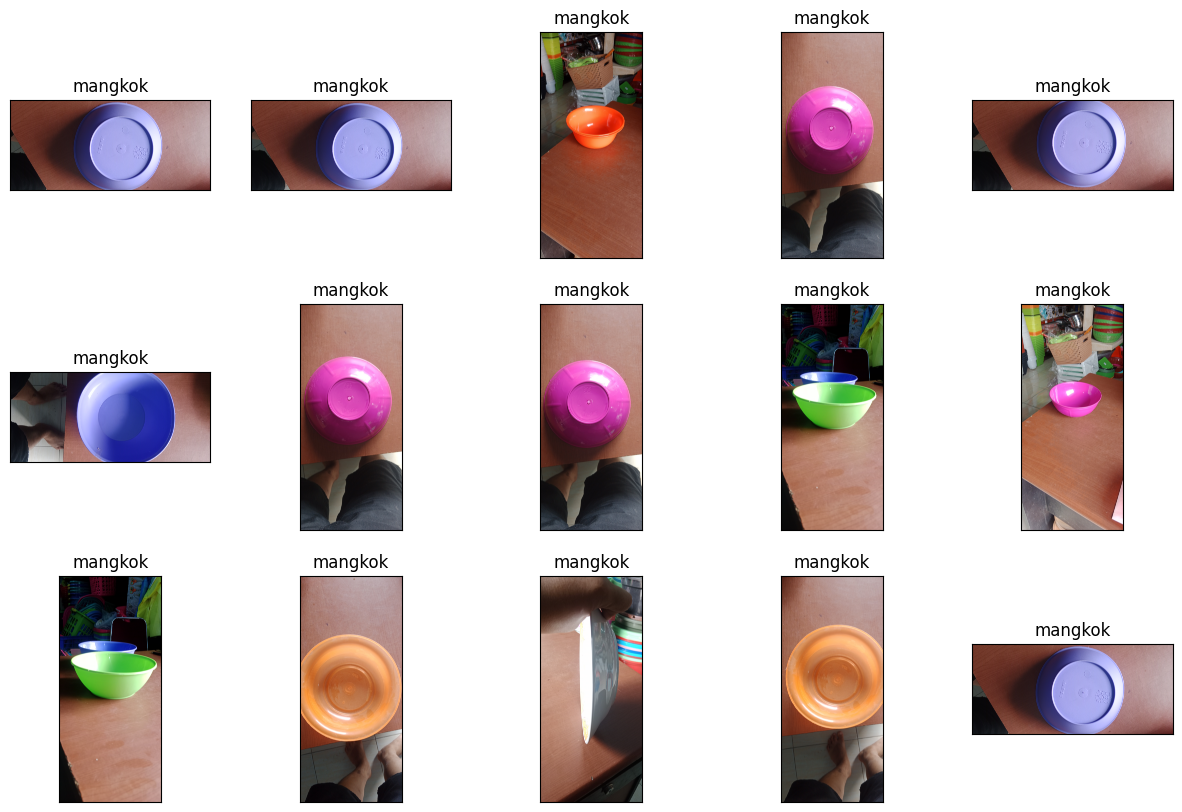

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [9]:
df.label.value_counts()

cangkir    100
piring     100
mangkok     84
Name: label, dtype: int64

In [10]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

cangkir    100
piring     100
mangkok     84
Name: label, dtype: int64

In [11]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [12]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (158, 2)
Shape of test data (86, 2)
Shape of validation data (40, 2)


In [13]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 158 validated image filenames belonging to 3 classes.
Found 86 validated image filenames belonging to 3 classes.
Found 40 validated image filenames belonging to 3 classes.


In [14]:
input_shape = (200, 200, 3)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [16]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
5/5 [==============================] - 38s 5s/step - loss: 1.1148 - accuracy: 0.3544 - val_loss: 1.0955 - val_accuracy: 0.3000
Epoch 2/100
5/5 [==============================] - 23s 5s/step - loss: 1.0843 - accuracy: 0.3861 - val_loss: 1.0981 - val_accuracy: 0.3000
Epoch 3/100
5/5 [==============================] - 24s 5s/step - loss: 1.0582 - accuracy: 0.4177 - val_loss: 1.0581 - val_accuracy: 0.5250
Epoch 4/100
5/5 [==============================] - 24s 5s/step - loss: 1.0205 - accuracy: 0.5000 - val_loss: 0.8925 - val_accuracy: 0.6500
Epoch 5/100
5/5 [==============================] - 23s 5s/step - loss: 0.9110 - accuracy: 0.6076 - val_loss: 0.6577 - val_accuracy: 0.7000
Epoch 6/100
5/5 [==============================] - 23s 5s/step - loss: 0.7907 - accuracy: 0.6646 - val_loss: 0.5172 - val_accuracy: 0.8000
Epoch 7/100
5/5 [==============================] - 23s 5s/step - loss: 0.7824 - accuracy: 0.6076 - val_loss: 0.9806 - val_accuracy: 0.6000
Epoch 8/100
5/5 [==========

In [17]:
model.save('model-1.h5')

In [18]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

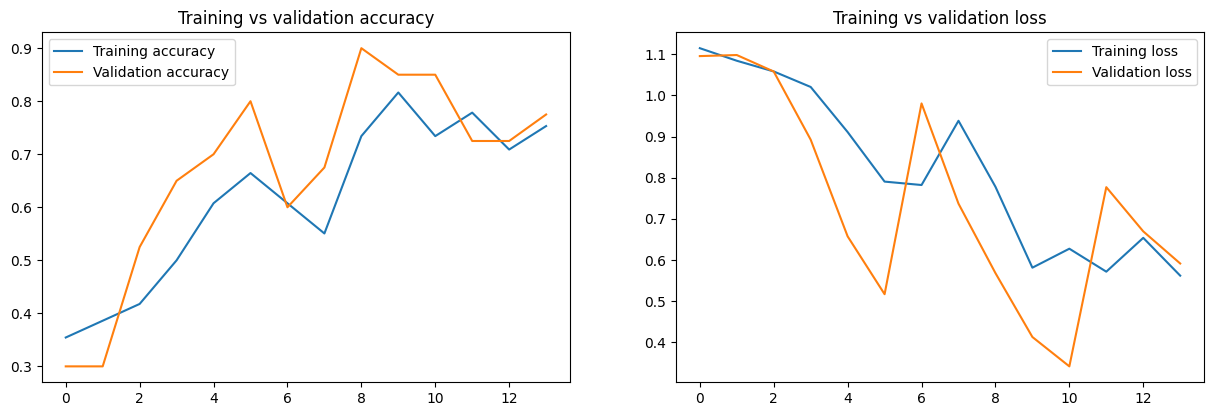

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [20]:
pred = model.predict(test)

3/3 [==============================] - 11s 4s/step


In [21]:
pred = np.argmax(pred, axis=1)

In [22]:
labels = train.class_indices

In [23]:
labels

{'cangkir': 0, 'mangkok': 1, 'piring': 2}

In [24]:
labels = dict((v,k) for k, v in labels.items())

In [25]:
 labels

{0: 'cangkir', 1: 'mangkok', 2: 'piring'}

In [26]:
y_pred = [labels[k] for k in pred]

In [27]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

     cangkir       0.86      0.58      0.69        31
     mangkok       0.71      0.86      0.77        28
      piring       0.65      0.74      0.69        27

    accuracy                           0.72        86
   macro avg       0.74      0.73      0.72        86
weighted avg       0.74      0.72      0.72        86



In [28]:
print(confusion_matrix(x_test.label, y_pred))

[[18  6  7]
 [ 0 24  4]
 [ 3  4 20]]


In [29]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 10s 3s/step - loss: 0.6557 - accuracy: 0.6628
